# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of image recognition with a binarized neural inspired at VGG-16, featuring 6 convolutional layers, 3 Max Pool layers and 3 Fully connected layers

## 1. Instantiate a Classifier
Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. By default there are three sets of weights to choose from - this example uses the StreetView house number set.

In [2]:
from pynq import Overlay
import cffi 
ROOT_BNN = "/opt/python3.6/lib/python3.6/site-packages/bnn/" 
ol = Overlay(ROOT_BNN+"/bitstreams/cnv-pynq-pynq.bit")
ol.download()
ffi = cffi.FFI()
ROOT_BNN = "/opt/python3.6/lib/python3.6/site-packages/bnn/" 
ffi.cdef("""
void load_parameters(const char* path);
unsigned int inference(const char* path, unsigned int results[64], int number_class, float *usecPerImage);
unsigned int* inference_multiple(const char* path, int number_class, int *image_number, float *usecPerImage, unsigned int enable_detail);
void free_results(unsigned int * result);
void deinit();
"""
)
NN_hw=ffi.dlopen(ROOT_BNN+"/libraries/python_hw-cnv-pynq.so")
NN_sw=ffi.dlopen(ROOT_BNN+"/libraries/python_sw-cnv-pynq.so")
ol.bitstream.timestamp

'2017/2/21 9:44:8 +57864'

# 2. Download the network parameters
The parameters of the network are downloaded in the Programmable logic memory, storing the trained weights on the Street view house number dataset. 

In [3]:
NN_hw.load_parameters(bytes(ROOT_BNN+"/params/streetview", encoding='utf-8'))

# 3. Open image to be classified
The image to be classified is loaded, showd and resized to meet the BNN requirements (scaled to 32x32 pixels)

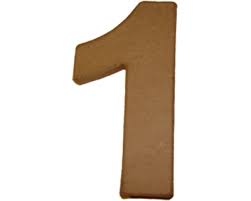

In [4]:
from PIL import Image
import numpy as np
im = Image.open('/home/xilinx/bnn/data/svhn/1.jpg')
# We resize the downloaded image to be 32x32 pixels as expected from the BNN
im

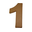

In [5]:
im.thumbnail((32, 32), Image.ANTIALIAS)
background = Image.new('RGBA', (32, 32), (0, 0, 0, 0))
background.paste(
    im, (int((32 - im.size[0]) / 2), int((32 - im.size[1]) / 2))
)
# We write the image into the format used in the Cifar-10 dataset for code compatibility 
im = (np.array(background))
r = im[:,:,0].flatten()
g = im[:,:,1].flatten()
b = im[:,:,2].flatten()
label = [1]

out = np.array(list(label) + list(r) + list(g) + list(b),np.uint8)
out.tofile("/home/xilinx/out.bin")
background

# 4. Loading classes description
We load the class description, that links the class identified from the BNN and the actual meaning of that class

In [6]:
import os
with open (os.path.join(ROOT_BNN+"/params/streetview/", "classes.txt")) as f:
    classes = [c.strip() for c in f.readlines()]

# 5. Launching BNN in hardware
The image is passed in the PL and the inference is performed

In [10]:
from wurlitzer import pipes
with pipes() as (stdout, stderr):
    class_out=NN_hw.inference(b"/home/xilinx/out.bin",ffi.NULL,10, ffi.NULL) 
print(stdout.read())    
print("Identified number: {0}".format(classes[class_out]))

Packing and interleaving CIFAR-10 inputs...
Running prebuilt CIFAR-10 test for 1 images...
Inference took 2249 microseconds, 2249 usec per image
Classification rate: 444.642 images per second

Identified number: 1


# 6. Launching BNN in software
The inference on the same image is performed in sofware on the ARM core

In [12]:
NN_sw.load_parameters(bytes(ROOT_BNN+"/params/streetview", encoding='utf-8'))

with pipes() as (stdout, stderr):
    class_out=NN_sw.inference(b"/home/xilinx/out.bin",ffi.NULL,10, ffi.NULL) 
print(stdout.read())    
print("Identified number: {0}".format(classes[class_out]))

Packing and interleaving CIFAR-10 inputs...
Running prebuilt CIFAR-10 test for 1 images...
Inference took 811389 microseconds, 811389 usec per image
Classification rate: 1.23245 images per second

Identified number: 1
